# Project 1 - ResNet Ablation Study

### 목표
- **CIFAR-10에 대해 일반 네트워크와 ResNet을 구현**
- **이 둘을 비교하여 ResNet 및 residual connection의 유효성 확인**

### (1) CIFAR-10 데이터셋 준비

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
    data_dir='~/aiffel/tensorflow_datasets'
)

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
ds_info.features["label"].num_classes

10

In [9]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### (2) 네트워크 블록 구성

In [10]:
# is_50 : True --> resnet_50
# is_plain :True --> no skip connection    
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1,is_50 = False,is_plain = False):
    # 입력 레이어
    x = input_layer
    if not is_50:
    # CNN 레이어
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
            )(x)
            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]    

                if identity_channel != channel:
                    identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
                # skip connection
                x = keras.layers.Add()([x,identity])   
            else:
                pass
    else :
        identity = x
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_1_conv{cnn_num}'
        )(x)
        x = keras.layers.Conv2D(
            filters=channel * 4,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_2_conv{cnn_num}'
        )(x)
        if not is_plain:
            identity_channel = identity.shape.as_list()[-1]    

            if identity_channel != channel:
                identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
            # skip connection
            x = keras.layers.Add()([x,identity])   
        else:
            pass
    #     Max Pooling 레이어
    # 마지막 블록 뒤에는 pooling을 하지 않음
    if identity.shape[1] != 1:        
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=2,
            name=f'block{block_num}_pooling'
        )(x)

    return x

In [11]:
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10,is_50 = False, is_plain = False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    if is_50:
        num_cnn_list = [3,4,6,3]
        channel_list = [64,128,256,512]
        num_classes = 10
        
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    #conv1층
    output = keras.layers.Conv2D(filters=64,
                       kernel_size = (2,2),
                       strides = 2,
                         padding = 'valid')(output)
    output = keras.layers.BatchNormalization()(output)
    
    #conv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size = (2,2),
                                      strides = 2,)(output)    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )    
    output = keras.layers.AveragePooling2D(padding = 'same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu', name='fc1')(output)    
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model


### (3) ResNet Complete Model

In [12]:
resnet_34 = build_resnet(is_50 = False)
resnet_50 = build_resnet(is_50 = True)
plain_resnet_34 = build_resnet(is_50 = False, is_plain = True)
plain_resnet_50 = build_resnet(is_50 = True, is_plain = True)

In [13]:
BATCH_SIZE = 256

In [14]:
EPOCH = 30

In [15]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [16]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   832         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 8, 8, 64)     0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [17]:
# 다른 모델 테스트
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 16, 16, 64)   832         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 16, 16, 64)   256         conv2d_4[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 8, 8, 64)     0           batch_normalization_17[0][0]     
____________________________________________________________________________________________

In [18]:
# 다른 모델 테스트
plain_resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)
plain_resnet_34.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 16, 16, 64)   832         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_34 (BatchNo (None, 16, 16, 64)   256         conv2d_8[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 8, 8, 64)     0           batch_normalization_34[0][0]     
____________________________________________________________________________________________

In [19]:
# 다른 모델 테스트
plain_resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)
plain_resnet_50.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 16, 16, 64)   832         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_51 (BatchNo (None, 16, 16, 64)   256         conv2d_12[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 8, 8, 64)     0           batch_normalization_51[0][0]     
____________________________________________________________________________________________

### (4) 모델 학습

In [20]:
with tf.device('/GPU:0'):
    history_34 = resnet_34.fit(
        ds_train,
        steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
        validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
        epochs=EPOCH,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

Epoch 1/30
195/195 [==============================] - 34s 97ms/step - loss: 2.0464 - accuracy: 0.3150 - val_loss: 3.1657 - val_accuracy: 0.1040
Epoch 2/30
195/195 [==============================] - 17s 85ms/step - loss: 1.6027 - accuracy: 0.4312 - val_loss: 2.7458 - val_accuracy: 0.1810
Epoch 3/30
195/195 [==============================] - 17s 88ms/step - loss: 1.4087 - accuracy: 0.5008 - val_loss: 1.6438 - val_accuracy: 0.4209
Epoch 4/30
195/195 [==============================] - 17s 88ms/step - loss: 1.2791 - accuracy: 0.5446 - val_loss: 1.4884 - val_accuracy: 0.4741
Epoch 5/30
195/195 [==============================] - 17s 86ms/step - loss: 1.1699 - accuracy: 0.5824 - val_loss: 1.4095 - val_accuracy: 0.5058
Epoch 6/30
195/195 [==============================] - 17s 86ms/step - loss: 1.0559 - accuracy: 0.6247 - val_loss: 1.4524 - val_accuracy: 0.4942
Epoch 7/30
195/195 [==============================] - 17s 87ms/step - loss: 0.9548 - accuracy: 0.6624 - val_loss: 1.4414 - val_accuracy:

In [21]:
with tf.device('/GPU:0'):
    history_50 = resnet_50.fit(
        ds_train,
        steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
        validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
        epochs=EPOCH,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

Epoch 1/30
195/195 [==============================] - 25s 87ms/step - loss: 2.0687 - accuracy: 0.3131 - val_loss: 2.7738 - val_accuracy: 0.1352
Epoch 2/30
195/195 [==============================] - 17s 85ms/step - loss: 1.5604 - accuracy: 0.4459 - val_loss: 2.6591 - val_accuracy: 0.1817
Epoch 3/30
195/195 [==============================] - 17s 85ms/step - loss: 1.3716 - accuracy: 0.5099 - val_loss: 1.8067 - val_accuracy: 0.3626
Epoch 4/30
195/195 [==============================] - 17s 85ms/step - loss: 1.2320 - accuracy: 0.5614 - val_loss: 1.4000 - val_accuracy: 0.4958
Epoch 5/30
195/195 [==============================] - 17s 85ms/step - loss: 1.1320 - accuracy: 0.5978 - val_loss: 1.4335 - val_accuracy: 0.5037
Epoch 6/30
195/195 [==============================] - 17s 85ms/step - loss: 1.0314 - accuracy: 0.6349 - val_loss: 1.4237 - val_accuracy: 0.5129
Epoch 7/30
195/195 [==============================] - 17s 85ms/step - loss: 0.9242 - accuracy: 0.6750 - val_loss: 1.3256 - val_accuracy:

In [22]:
with tf.device('/GPU:0'):
    history_plain_34 = plain_resnet_34.fit(
        ds_train,
        steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
        validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
        epochs=EPOCH,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

Epoch 1/30
195/195 [==============================] - 25s 87ms/step - loss: 1.9758 - accuracy: 0.3267 - val_loss: 2.8677 - val_accuracy: 0.1150
Epoch 2/30
195/195 [==============================] - 17s 85ms/step - loss: 1.5438 - accuracy: 0.4504 - val_loss: 2.5019 - val_accuracy: 0.2106
Epoch 3/30
195/195 [==============================] - 17s 86ms/step - loss: 1.3718 - accuracy: 0.5044 - val_loss: 1.6481 - val_accuracy: 0.4259
Epoch 4/30
195/195 [==============================] - 17s 85ms/step - loss: 1.2423 - accuracy: 0.5553 - val_loss: 1.4307 - val_accuracy: 0.4887
Epoch 5/30
195/195 [==============================] - 17s 85ms/step - loss: 1.1169 - accuracy: 0.5995 - val_loss: 1.4278 - val_accuracy: 0.4941
Epoch 6/30
195/195 [==============================] - 17s 86ms/step - loss: 1.0054 - accuracy: 0.6403 - val_loss: 1.4290 - val_accuracy: 0.5050
Epoch 7/30
195/195 [==============================] - 17s 85ms/step - loss: 0.9233 - accuracy: 0.6737 - val_loss: 1.3586 - val_accuracy:

In [23]:
with tf.device('/GPU:0'):
    history_plain_50 = plain_resnet_50.fit(
        ds_train,
        steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
        validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
        epochs=EPOCH,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

Epoch 1/30
195/195 [==============================] - 25s 88ms/step - loss: 2.0190 - accuracy: 0.3246 - val_loss: 2.7554 - val_accuracy: 0.1567
Epoch 2/30
195/195 [==============================] - 17s 85ms/step - loss: 1.5552 - accuracy: 0.4421 - val_loss: 2.3907 - val_accuracy: 0.2452
Epoch 3/30
195/195 [==============================] - 16s 85ms/step - loss: 1.3622 - accuracy: 0.5136 - val_loss: 1.6408 - val_accuracy: 0.4037
Epoch 4/30
195/195 [==============================] - 17s 86ms/step - loss: 1.2345 - accuracy: 0.5561 - val_loss: 1.4227 - val_accuracy: 0.4976
Epoch 5/30
195/195 [==============================] - 17s 85ms/step - loss: 1.1205 - accuracy: 0.6013 - val_loss: 1.4253 - val_accuracy: 0.5040
Epoch 6/30
195/195 [==============================] - 17s 85ms/step - loss: 1.0058 - accuracy: 0.6418 - val_loss: 1.3631 - val_accuracy: 0.5177
Epoch 7/30
195/195 [==============================] - 17s 86ms/step - loss: 0.9225 - accuracy: 0.6740 - val_loss: 1.3852 - val_accuracy:

### (5) 모델 결과 비교

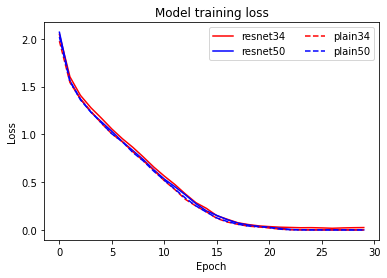

In [31]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'b')
plt.plot(history_plain_34.history['loss'], 'r', linestyle='--')
plt.plot(history_plain_50.history['loss'], 'b', linestyle='--')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'resnet50', 'plain34', 'plain50'], loc='upper right', ncol=2)
plt.show()

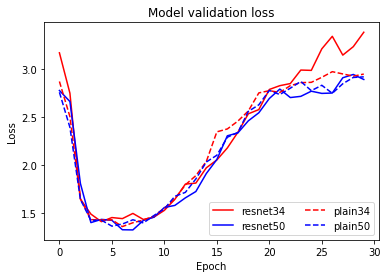

In [35]:
plt.plot(history_34.history['val_loss'], 'r')
plt.plot(history_50.history['val_loss'], 'b')
plt.plot(history_plain_34.history['val_loss'], 'r', linestyle='--')
plt.plot(history_plain_50.history['val_loss'], 'b', linestyle='--')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'resnet50', 'plain34', 'plain50'], loc='lower right', ncol=2)
plt.show()

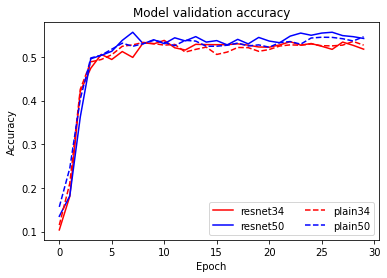

In [34]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.plot(history_plain_34.history['val_accuracy'], 'r', linestyle='--')
plt.plot(history_plain_50.history['val_accuracy'], 'b', linestyle='--')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'resnet50','plain34', 'plain50'], loc='lower right', ncol=2)
plt.show()

- resnet50, plain50이 accuracy가 더 높게 나타났다.
- deeper model에서 accuracy가 더 높다는 것을 알 수 있었다.

- 34 layers에서는 잘 나타나지 않았지만 50 layers에서는 plain보다 resnet이 더 accuracy가 높았다.
- resnet의 **skip connection**이 deeper model에서 **vanishing gradient** 문제를 해결함을 알 수 있었다